Copyright (c) 2022 José Ángel de Bustos Pérez

May be copied or modified under the terms of the GNU General Public License v3.0.  See https://www.gnu.org/licenses/gpl-3.0.html

# Testing ResNet50 (fight-detection-surv Dataset)

This notebook tests Resnet50 models and print the Confusion Matrix.

The h5 model is not included due to it exceeds GitHub storage limits.

https://github.com/sayibet/fight-detection-surv-dataset


## Check environment

In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)    

print("Tensorflow version: %s\n" % tf.__version__)

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2022-09-18 16:26:43.911078: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-09-18 16:26:44.413346: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-09-18 16:26:44.442976: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-18 16:26:44.443043: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.69GiB deviceMemoryBandwidth: 871.81GiB/s
2022-09-18 16:26:44.443052: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-09-18 16:26:44.445274: I tensorflow/stream_executor/

Tensorflow version: 2.5.3

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5144937661547658309
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22996975616
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10507484678604724436
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6"
]
Num GPUs Available:  1


on_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2022-09-18 16:26:44.461648: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-09-18 16:26:44.732494: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-09-18 16:26:44.732517: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      0 
2022-09-18 16:26:44.732521: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1277] 0:   N 
2022-09-18 16:26:44.732622: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-18 16:26:44.732697: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-18 16:

## Hyperparameters and data preparation

In [2]:
import numpy as np
import string
import os

video_path_test = '/home/jadebustos/tfm/datasets/fight-detection-surv-dataset'

# Hyperparams
IMAGE_SIZE = 200
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE, IMAGE_SIZE

input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)

DROPOUT = 0.5

labels = ['violence', 'nonviolence']
labels_dict = {}
labels_dict['violence'] = 0
labels_dict['nonviolence'] = 1

# get files in directory
def get_files_dir(directory):
    return os.listdir(directory)

files_dir_violence = get_files_dir(os.path.join(video_path_test, 'violence'))
print("\nTest videos (violence): %d" % len(files_dir_violence))
files_dir_nonviolence = get_files_dir(os.path.join(video_path_test, 'nonviolence'))
print("Test videos (nonviolence): %d" % len(files_dir_nonviolence))


Test videos (violence): 150
Test videos (nonviolence): 150


## Model creation

In [3]:
import time
import tensorflow as tf
import tensorflow.keras as K

# load the Keras resnet50
resnet50_model = tf.keras.applications.ResNet50(
    include_top = False,
    weights = 'imagenet',
#    input_tensor = K.Input(shape=input_shape),
    input_shape = input_shape,
)

for layer in resnet50_model.layers:
    layer.trainable = False

model = K.Sequential()
model.add(resnet50_model)
model.add(K.layers.Flatten())
model.add(K.layers.Dense(512, activation="relu"))
model.add(K.layers.Dropout(DROPOUT))
model.add(K.layers.Dense(512, activation="relu"))
model.add(K.layers.Dropout(DROPOUT))
model.add(K.layers.Dense(16, activation="relu"))
model.add(K.layers.Dropout(DROPOUT))
model.add(K.layers.Dense(16, activation="relu"))
model.add(K.layers.Dense(1, activation='sigmoid'))

model.summary()

2022-09-18 16:26:44.763614: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-18 16:26:44.763700: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.69GiB deviceMemoryBandwidth: 871.81GiB/s
2022-09-18 16:26:44.763741: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-18 16:26:44.763786: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-18 16:26:44.763821: I tensorflow/core/comm

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               51380736  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                8

## Loading the model

Load the model to test:

In [4]:
import numpy as np 
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

h5_model = "trained-resnet50-b16-e128-16frames-acc-dropout-0.5-alt3.h5"
model.load_weights(h5_model)

## Testing the model

The video will be classified analyzing one of each frames_step:

* If probability is greater than 0.5 the frame will be labeled as non violence, if not will be labeled as violence with probability 1 - probability.
* The video will be labeled as the most frequent label among frames analyzed and with probability the mean of the most common label probabilities.

In [5]:
import cv2
import os

import numpy as np

# test model
def test_model(videos, frame_step, videos_path):
    predictions = {}

    # test model using test dataset
    for item in videos:                   
        # open video
        video_path = os.path.join(videos_path, item)
        vidcap = cv2.VideoCapture(video_path)
        length = int(vidcap. get(cv2. CAP_PROP_FRAME_COUNT))
        video_frames = []
        # select frames every 5 frames
        frame_index = 1
        while frame_index <= length:
            try:
                # position video frame
                vidcap.set(1, frame_index)
                sucess, image = vidcap.read()
                resized = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))                  
                video_frames.append(resized)                
                    
                # increment index
                frame_index += frames_step
            except Exception as e:
                frame_index += frames_step
    
        # close video
        vidcap.release()
            
        # predict using model
        frames = (np.array(video_frames).astype('float32'))/255
        prediction = model.predict(frames) 
        
        violence = []
        nonviolence = []
        for pred in prediction:
            if pred[0] >= 0.5:
                nonviolence.append(pred[0])
            else:
                violence.append(1. - pred[0])

        predictions[item] = {}
        if len(violence) >= len(nonviolence):
            predictions[item]['violence'] = np.mean(violence)
        else:
            predictions[item]['nonviolence'] = np.mean(nonviolence)
    
    return predictions

# read every frame_steps frames to test the video
frames_step = 5
   
# violence predictions
video_dir = os.path.join(video_path_test, 'violence')
videos = get_files_dir(video_dir)
predictions_violence = test_model(videos, frames_step, os.path.join(video_path_test, 'violence'))
# nonviolence predictions
video_dir = os.path.join(video_path_test, 'nonviolence')
videos = get_files_dir(video_dir)
predictions_nonviolence = test_model(videos, frames_step, os.path.join(video_path_test, 'nonviolence'))

2022-09-18 16:26:46.338793: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-09-18 16:26:46.357747: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3609600000 Hz
2022-09-18 16:26:46.659412: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-09-18 16:26:47.174491: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8401
2022-09-18 16:26:47.817202: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-18 16:26:47.817227: W tensorflow/stream_executor/gpu/asm_compiler.cc:56] Couldn't invoke ptxas --version
2022-09-18 16:26:47.817515: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-18 16:26:47.817548: W tensorflow/stream_executor/gpu/redzone_allocator.cc:31

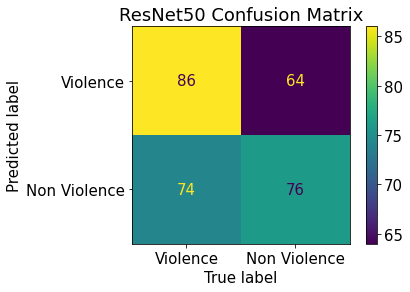

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams.update({'font.size': 15})

# 0 - Violence
# 1 - Nonviolence
real_data = []
predicted_data = []

for item in predictions_violence.keys():
    real_data.append('Violence')
    if 'violence' in predictions_violence[item].keys():
        predicted_data.append('Violence')
    else:
        predicted_data.append('Non-Violence')
        
for item in predictions_nonviolence.keys():
    real_data.append('Non-Violence')
    if 'violence' in predictions_nonviolence[item].keys():
        predicted_data.append('Violence')
    else:
        predicted_data.append('Non-Violence')

cf_matrix = confusion_matrix(real_data, predicted_data, labels=['Violence', 'Non-Violence'])

# create the Confusion Matrix Display 
cmd_obj = ConfusionMatrixDisplay(cf_matrix, 
                                 display_labels=['Violence', 'Non Violence'])

cmd_obj.plot()
cmd_obj.ax_.set(
                title='ResNet50 Confusion Matrix', 
                xlabel='True label', 
                ylabel='Predicted label')
plt.show()

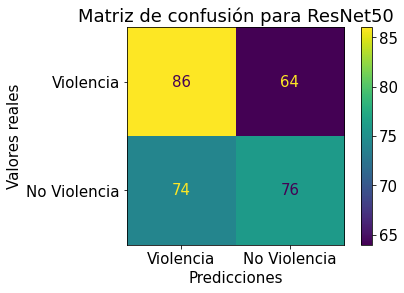

In [10]:
# create the Confusion Matrix Display 
cmd_obj_es = ConfusionMatrixDisplay(cf_matrix, 
                                 display_labels=['Violencia', 'No Violencia'])

cmd_obj_es.plot()
cmd_obj_es.ax_.set(
                title='Matriz de confusión para ResNet50', 
                xlabel='Predicciones', 
                ylabel='Valores reales')
plt.show()

Model performance:

In [11]:
TP = cf_matrix[0][0]
TN = cf_matrix[1][1]
FP = cf_matrix[0][1]
FN = cf_matrix[1][0]

accuracy = (TP + TN)/(len(files_dir_violence) + len(files_dir_nonviolence))
recall = TP/(TP + FN)
precision = TP /(TP + FP)
specificity = TN/(TN + FP)
f1 = 2* (precision * recall)/(precision + recall)

print("Accuracy: %.2f" % (100 * accuracy))
print("Recall: %.2f" % (100 * recall))
print("Precision: %.2f" % (100 * precision))
print("Specificity: %.2f" % (100 * specificity))
print("F1: %.4f" % f1)

Accuracy: 54.00
Recall: 53.75
Precision: 57.33
Specificity: 54.29
F1: 0.5548
